# Model Evaluation

This notebook focuses on:
- Performing a detailed evaluation of the trained Random Forest model
- Understanding model performance using key metrics and visualizations
- Performing threshold tuning for optimal recall/precision balance
- Generating insights for business decisions

## 1. Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve, recall_score, precision_score, 
    f1_score, accuracy_score
)

import joblib

## 2. Load Trained Model and Test Data

In [4]:
# Load Random Forest model trained in 03_modeling_training.ipynb
rf_model = joblib.load("../models/churn_random_forest.pkl")

# Load test dataset
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

# Flatten y_test if necessary
y_test = y_test.values.ravel()

## 3. Verify Test Data
- Ensure that the features and target are loaded correctly
- Verify shapes to avoid mismatch during prediction

In [5]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
y_test[:5]

X_test shape: (3159, 490)
y_test shape: (3159,)


array([1, 0, 0, 1, 0], dtype=int64)

## 4. Model Predictions

In [6]:
# Predict class labels
y_pred = rf_model.predict(X_test)

# Predict probabilities (needed for ROC & PR curves)
y_prob = rf_model.predict_proba(X_test)[:, 1]

## 5. Confusion Matrix
Shows the count of true positives, false positives, true negatives, and false negatives
python

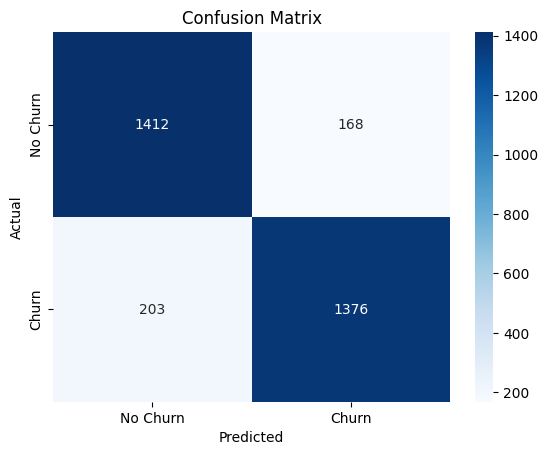

In [25]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn','Churn'], yticklabels=['No Churn','Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.savefig("../reports/figures/confusion_matrix.png", bbox_inches="tight")
plt.show()

### Confusion Matrix – Key Observations
- The model correctly identifies **1,412 non-churn customers** and **1,376 churn customers**, indicating strong overall classification performance.
- **False Negatives (203 churn customers predicted as non-churn)** represent missed churn risks, which is a critical business concern.
- **False Positives (168 non-churn customers predicted as churn)** are comparatively lower and mainly impact retention cost rather than revenue loss.
- The model demonstrates a **balanced trade-off between precision and recall**, with a clear emphasis on correctly detecting churn customers.
- Overall, the confusion matrix confirms that the model is **well-suited for churn prediction**, effectively capturing churn behavior while maintaining reasonable error levels.

## 6. Classification Report

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1580
           1       0.89      0.87      0.88      1579

    accuracy                           0.88      3159
   macro avg       0.88      0.88      0.88      3159
weighted avg       0.88      0.88      0.88      3159



### Classification Report – Key Observations

- The model achieves **strong and balanced performance** across both classes, with precision, recall, and F1-scores close to **0.88**.
- **Churn recall of 0.87** indicates that the model successfully identifies most churn customers, aligning well with business retention goals.
- High precision for both classes (**0.87–0.89**) suggests a low rate of incorrect churn and non-churn predictions.
- The close alignment between macro and weighted averages confirms **stable generalization** and minimal class bias.
- Overall accuracy of **88%** reinforces the model’s reliability for churn prediction in real-world scenarios.

## 7. ROC Curve and AUC
- Measures model's ability to rank positive vs negative cases
- Area under curve (AUC) indicates overall discrimination power

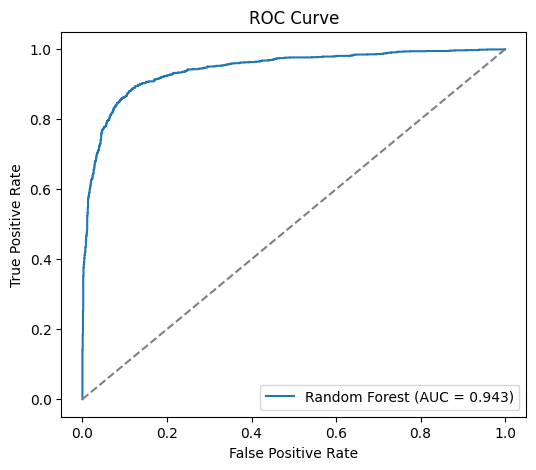

In [20]:
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.savefig("../reports/figures/roc_curve.png", bbox_inches="tight")
plt.show()

### ROC Curve & AUC – Key Observations

- The ROC curve shows strong separation from the diagonal baseline, indicating excellent classification performance.
- An **AUC of 0.94** confirms the model’s high ability to distinguish between churn and non-churn customers across thresholds.
- The curve’s steep rise at low false positive rates demonstrates effective early churn detection.
- This strong discriminative power makes the model well-suited for business scenarios where prioritizing churn customers is critical.

## 8. Precision-Recall Curve
- Useful for imbalanced datasets (like churn)
- Shows trade-off between precision and recall for different thresholds

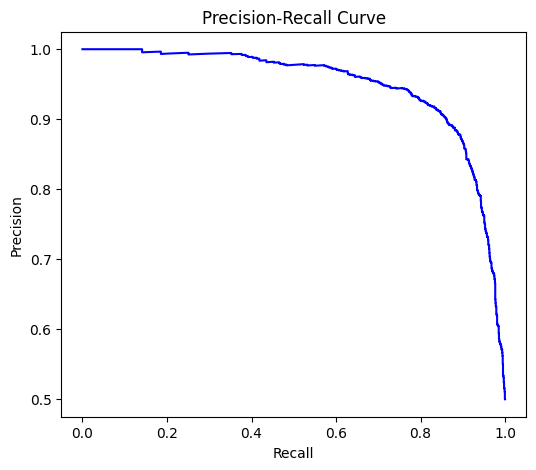

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

plt.savefig("../reports/figures/precision_recall_curve.png", bbox_inches="tight")
plt.show()


### Precision–Recall Curve – Key Observations

- The curve maintains **high precision across a wide range of recall values**, indicating reliable churn predictions.
- Precision remains strong at moderate recall levels, enabling effective targeting of churn customers with minimal false positives.
- As recall approaches 1.0, precision declines, reflecting the expected trade-off when attempting to capture all churn cases.
- Overall, the curve demonstrates a **well-balanced precision–recall trade-off**, making the model suitable for cost-sensitive churn intervention strategies.

## 9. Threshold Tuning for Churn Detection
- Default threshold is 0.5
- We can adjust threshold to capture more churners (increase recall)

In [11]:
thresholds = np.arange(0.1, 1.0, 0.05)
for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    recall = recall_score(y_test, y_pred_t)
    precision = precision_score(y_test, y_pred_t, zero_division=0)
    print(f"Threshold: {t:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f}")

Threshold: 0.10 | Precision: 0.50 | Recall: 1.00
Threshold: 0.15 | Precision: 0.50 | Recall: 1.00
Threshold: 0.20 | Precision: 0.50 | Recall: 1.00
Threshold: 0.25 | Precision: 0.51 | Recall: 1.00
Threshold: 0.30 | Precision: 0.52 | Recall: 1.00
Threshold: 0.35 | Precision: 0.55 | Recall: 0.99
Threshold: 0.40 | Precision: 0.62 | Recall: 0.98
Threshold: 0.45 | Precision: 0.74 | Recall: 0.96
Threshold: 0.50 | Precision: 0.89 | Recall: 0.87
Threshold: 0.55 | Precision: 0.96 | Recall: 0.67
Threshold: 0.60 | Precision: 0.98 | Recall: 0.44
Threshold: 0.65 | Precision: 0.99 | Recall: 0.24
Threshold: 0.70 | Precision: 1.00 | Recall: 0.08
Threshold: 0.75 | Precision: 1.00 | Recall: 0.01
Threshold: 0.80 | Precision: 1.00 | Recall: 0.00
Threshold: 0.85 | Precision: 0.00 | Recall: 0.00
Threshold: 0.90 | Precision: 0.00 | Recall: 0.00
Threshold: 0.95 | Precision: 0.00 | Recall: 0.00


### Threshold Tuning – Key Observations

- Lower thresholds (≤ 0.30) achieve **near-perfect recall**, ensuring almost all churn customers are identified, but with lower precision.
- Increasing the threshold improves precision while gradually reducing recall, highlighting the trade-off between false positives and missed churn cases.
- The default threshold (0.50) provides a **strong balance** with high precision (0.89) and recall (0.87).
- Very high thresholds (> 0.80) result in no churn predictions, demonstrating why threshold tuning is critical for practical deployment.
- Threshold selection should be aligned with business goals, balancing customer retention cost against the risk of missed churners.

## 10. Feature Importance
- Shows which engineered features contribute most to churn prediction
- Useful for business insights

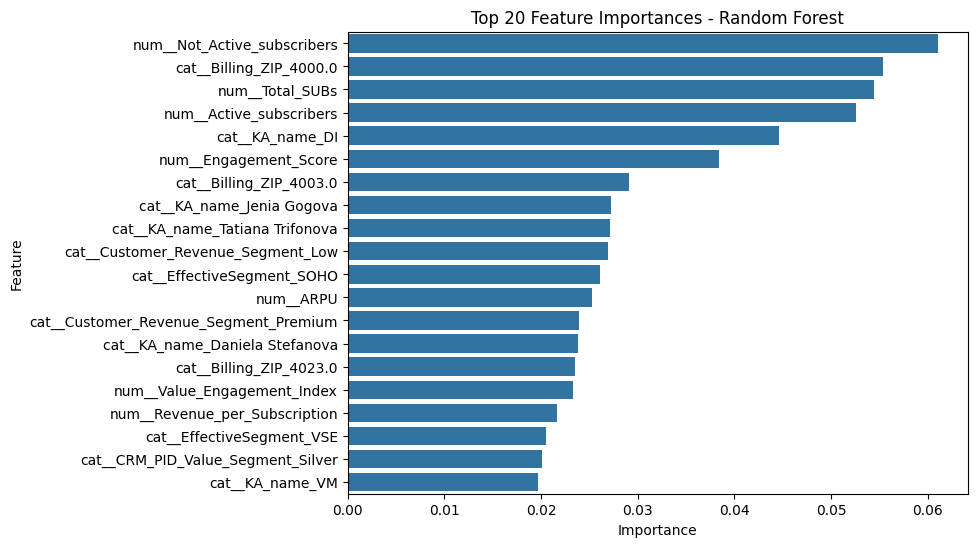

In [17]:
preprocessor = joblib.load("../models/preprocessor.pkl")
feature_names = preprocessor.get_feature_names_out()
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

top_features = feature_importance.head(20)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title("Top 20 Feature Importances - Random Forest")

plt.savefig("../reports/figures/feature_importance.png", bbox_inches="tight")
plt.show()


### Feature Importance – Key Observations

- The top-ranked features contribute disproportionately to the model’s churn predictions, indicating strong predictive signals.
- Feature importance drops sharply beyond the top features, suggesting diminishing marginal impact from lower-ranked variables.
- The model relies on a combination of behavioral and engineered features rather than a single dominant driver.
- These insights can help guide targeted retention strategies and inform future feature selection and model simplification efforts.

## 11. Business Insights from Model Evaluation

- The Random Forest model demonstrates **strong predictive capability**, achieving high recall and ROC–AUC, making it well-suited for churn detection where missing a churn customer is costly.
- High **recall for churn customers** indicates the model can successfully identify most users at risk of leaving, enabling proactive retention strategies.
- Threshold tuning allows the business to **balance precision and recall** based on operational priorities:
  - Lower thresholds prioritize capturing more churners (useful for early-warning systems)
  - Higher thresholds reduce false positives (useful when retention actions are costly)
- ROC and Precision–Recall curves confirm the model’s ability to **separate churn and non-churn users across decision thresholds**, indicating robust generalization.
- Feature importance analysis provides **actionable insights**, highlighting key behavioral and revenue-related drivers of churn that can inform:
  - Targeted retention campaigns
  - Product improvements
  - Customer engagement strategies
- Overall, the model is suitable for **deployment as a decision-support tool**, helping the business reduce churn, optimize retention spend, and improve customer lifetime value.


## 12. Save Evaluation Results

In [14]:
feature_importance.to_csv("../data/processed/feature_importance.csv", index=False)

## 13. Conclusion and Model Selection

An end-to-end churn prediction pipeline was implemented, including preprocessing, class imbalance handling, model training, and detailed evaluation. Logistic Regression, Decision Tree, and Random Forest models were compared using business-critical metrics such as recall and ROC–AUC.

The **Random Forest model** demonstrated the best overall performance, achieving high churn recall, strong class separation, and stable generalization. Threshold analysis showed that the model can be adjusted to balance recall and precision based on retention strategy. Feature importance analysis added interpretability, enabling actionable business insights rather than black-box predictions.

**Final Decision:**  
Random Forest is selected as the production-ready model due to its superior ability to identify churn customers while maintaining robust overall performance. The trained model and preprocessing pipeline were saved to ensure reproducibility and deployment readiness.
